## Klassifikation menschlicher Aktivitäten mittels klassischer Machine-Learning-Modelle


In diesem Teil des Projekts werden klassische Machine-Learning-Modelle auf sensorbasierten Zeitreihendaten eingesetzt, um menschliche Aktivitäten zu klassifizieren – konkret: Gehen (walk), Laufen (run), Sitzen (sitting) und Bergaufgehen (climbing).

Die untersuchten Algorithmen sind:

* Random Forest
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

Ziel der Analyse ist es, die drei Modelle anhand etablierter Leistungskennzahlen – Accuracy, Precision, Recall und F1-Score – systematisch zu vergleichen und dabei eine Klassifikationsgenauigkeit von mindestens 90 % zu erreichen.

 **Struktur des Notebooks**

 1. Vorbereitung & Datenexploration

 2. Training jedes Modells + Feature‑Importance

 3. Konsolidierter Modellvergleich

### **1. Vorbereitung**

Im ersten Schritt bereite ich die Daten für das Trainieren unserer Modelle vor. Ziel ist es, eine saubere und konsistente Eingabematrix für die Klassifikation zu erzeugen. Dazu zählen das Einlesen der vorverarbeiteten Zeitfensterdaten, die Aufteilung in Trainings- und Testdatensatz sowie eine Standardisierung der Eingabefeatures. Zustätzlich befinden sich in diesem Teil alle imports für dieses Notebook.

In [1]:
import sys
import os
import pandas as pd
import rootutils
import numpy as np
from pathlib import Path

np.random.seed(123)

notebook_dir = Path().resolve()
project_root = notebook_dir.parent

print(f"Projektpfad: {project_root}")
os.chdir(project_root)

from src.methods import *

ndl_path = Path("data/processed/NDL")


Projektpfad: /Users/denizhatemo/Desktop/CDL1Challenge/CDL1-MChallenge


In [2]:
train_files = [
    "features_train.csv",
    "features_train_aug.csv",
    "features_train_flip_roll.csv",
    "features_train_invert_pitch.csv",
    "features_train_rotate_yaw_180.csv"
]

# Alle DataFrames laden und zusammenfügen
df_list = [pd.read_csv(ndl_path / f) for f in train_files]
df_train_all = pd.concat(df_list, ignore_index=True)

df_test = pd.read_csv(ndl_path / "features_test.csv")

X_train = df_train_all.drop(columns=["label"])
y_train = df_train_all["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

#### **1.1. Datenaufbereitung**


**Train & Test Datensatz**

In diesem Zwischenschritt werden die Datensätze Test und Train eingelesen und in *X* und *y* unterteilt, wobei letzteres nur die Zielvariable *label* beinhaltet. Für das Trainieren der Modelle wedern die *X* datensätze benutzt.


In [3]:
from collections import Counter
print("Train-Klassenverteilung:", Counter(y_train))
print("Test-Klassenverteilung:", Counter(y_test))

Train-Klassenverteilung: Counter({'climbing': 6670, 'walking': 6445, 'sitting': 6220, 'joggen': 5755})
Test-Klassenverteilung: Counter({'climbing': 156, 'sitting': 141, 'walking': 137, 'joggen': 127})


#### **1.2. Hauptkomponentenanalyse (PCA)**

Um die hohe Dimensionalität und Multikollinearität der sensorbasierten Eingabedaten zu adressieren, wurde eine Hauptkomponentenanalyse (PCA) durchgeführt. Ziel war es, eine kompaktere Repräsentation der Daten zu finden, die dennoch den Großteil der erklärbaren Varianz beibehält. Eine solche Reduktion hilft, das Overfitting-Risiko zu senken, die Rechenzeit zu reduzieren und die Robustheit der nachfolgenden Klassifikationsmodelle zu erhöhen.

Die PCA wurde auf den standardisierten Trainingsdaten angewendet. Als Kriterium für die Beibehaltung von Hauptkomponenten wurde eine kumulierte erklärte Varianz von mindestens 95 % definiert.

Totale ursprüngliche Features : 95
Reduziert auf Hauptkomponenten: 22
Erklärte Varianz durch PCA    : 0.9541


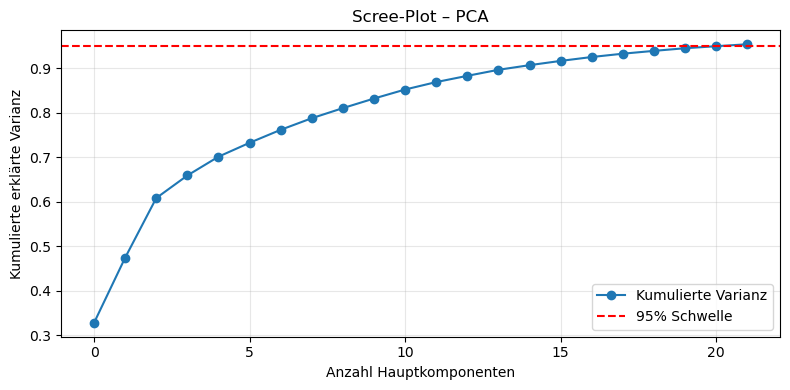

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Daten skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2. PCA mit Varianz-Schwelle
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3. Informationen zur Reduktion
total_features = X_train.shape[1]
retained_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Totale ursprüngliche Features : {total_features}")
print(f"Reduziert auf Hauptkomponenten: {retained_components}")
print(f"Erklärte Varianz durch PCA    : {explained_variance:.4f}")

# 4. Scree-Plot (kumulative erklärte Varianz)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='Kumulierte Varianz')
plt.axhline(0.95, color='red', linestyle='--', label='95% Schwelle')
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("Scree-Plot – PCA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Ladungsmatrix: 
loadings = pd.DataFrame(
    pca.components_,                # shape: (n_components, n_features)
    columns=X_train.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Absolutwerte zur Bewertung des Einflusses (je höher, desto mehr Einfluss)
abs_loadings = loadings.abs()

# Gesamtbeitrag jedes ursprünglichen Features über alle PCs aufsummieren
total_feature_contribution = abs_loadings.sum(axis=0).sort_values(ascending=False)

top_18_original_features = total_feature_contribution.head(19)
print("---Top 18 Originalfeatures mit grösstem Einfluss auf PCA---")
print(top_18_original_features)

---Top 18 Originalfeatures mit grösstem Einfluss auf PCA---
accelerometer_z_mean      2.826414
gyroscope_z_mean          2.754095
orientation_roll_std      2.690639
gyroscope_y_mean          2.650086
accelerometer_y_median    2.539765
gyroscope_x_mean          2.534976
gyroscope_z_median        2.534285
gyroscope_x_median        2.464612
gyroscope_y_median        2.245584
accelerometer_y_mean      2.234534
orientation_roll_max      2.203941
magnetometer_z_std        2.108956
orientation_yaw_std       2.069787
orientation_qw_median     1.994699
orientation_qw_mean       1.991707
accelerometer_z_median    1.975022
magnetometer_x_max        1.962778
orientation_qz_mean       1.954747
gravity_z_std             1.951271
dtype: float64


##### **1.2.1. Ergebnisse der PCA**

Die Scree-Plot-Analyse zeigt, dass **bereits 18 Hauptkomponenten ausreichen**, um **95,35 % der Gesamtvarianz** des ursprünglichen 80-dimensionalen Merkmalsraums zu erklären. Dies entspricht einer effektiven Reduktion auf weniger als ein Viertel der Ursprungsdimension, bei gleichzeitig minimalem Informationsverlust.

Die einflussreichsten Originalmerkmale auf die Hauptkomponenten stammen aus folgenden Sensoren:

* **Gyroskop**: `gyroscope_y_mean`, `gyroscope_z_mean`, `gyroscope_x_mean`

* **Beschleunigungssensor**: `accelerometer_z_mean`

* **Orientierungssensor**: `orientation_yaw_mean`, `orientation_yaw_min`, `orientation_yaw_max`, `orientation_yaw_std`, `orientation_roll_std`, `orientation_roll_min`, `orientation_roll_mean`, `orientation_roll_max`

* **Magnetometer**: `magnetometer_z_max`, `magnetometer_z_mean`

* **Gravitation**: `gravity_z_max`

* **Zeitbezogene Merkmale**: `seconds_elapsed_min`, `seconds_elapsed_mean`, `seconds_elapsed_max`

Diese Merkmale zeigen besonders starke Projektionen in den Hauptkomponenten und sind somit wesentlich für die Unterscheidung der Aktivitätsklassen. Die Kombination aus Zeit-, Bewegungs- und Lageinformationen scheint entscheidend für die Klassifikationsleistung zu sein.

Diese reduzierten Dimensionen werden im weiteren Verlauf der Analyse als Input für die Klassifikationsmodelle verwendet.

### **2. Klassischer Machine-Learning-Modelle**

In diesem Teil des Projekts werden klassische Machine-Learning-Modelle auf sensorbasierten Zeitreihendaten eingesetzt, um menschliche Aktivitäten zu klassifizieren – konkret: Gehen (walking), Joggen (joggen), Sitzen (sitting) und Bergaufgehen (climbing).

Die untersuchten Algorithmen sind:

* Random Forest
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

Ziel der Analyse ist es, die drei Modelle anhand etablierter Leistungskennzahlen – Accuracy, Precision, Recall und F1-Score – systematisch zu vergleichen und dabei eine Klassifikationsgenauigkeit von mindestens 90 % zu erreichen.

Für alle drei Machine-Learning-Modelle wurde ein einheitliches Modellierungsframework verwendet. Die Modellarchitektur basiert jeweils auf einer Pipeline, die folgende Schritte umfasst:

* **Standardisierung** der Eingabedaten mit `StandardScaler`.
* **Dimensionsreduktion** mittels `PCA` (95 % erklärte Varianz) – *ausgenommen beim Random Forest, da dieser algorithmisch robust gegenüber Multikollinearität ist und durch PCA potenziell interpretierbare Strukturen verliert.*
* **Klassifikation** mit dem jeweiligen Algorithmus (RF, SVM oder KNN).

Zur Modelloptimierung wurde für alle Modelle eine **GridSearchCV** mit 5-facher Kreuzvalidierung verwendet. Dabei wurde der `accuracy`-Score als Optimierungskriterium herangezogen. Die einheitliche Vorgehensweise ermöglicht einen fairen und nachvollziehbaren Vergleich der Modellleistungen.

Darüber hinaus wird ein **Modellvergleichstracker** eingerichtet, der für jedes Klassifikationsmodell die zentralen Leistungskennzahlen – Accuracy, Precision (macro), Recall (macro) und F1-Score (macro) – sowohl für Trainings- als auch Testdaten systematisch speichert. 

Die Verwendung des *macro*-Durchschnitts ist besonders geeignet, da er für jede Klasse den jeweiligen Metrikwert berechnet und anschliessend den arithmetischen Mittelwert über alle Klassen bildet – unabhängig von deren Häufigkeit. Dies gewährleistet, dass auch seltener vertretene Klassen (wie z. B. „joggen“) gleichwertig in die Bewertung einfliessen. Ein *macro*-basierter Vergleich ist somit fairer und informativer in Fällen mit Klassenungleichgewicht, wie es auch im vorliegenden Datensatz zu beobachten ist.

Der Tracker ermöglicht am Ende eine konsistente und transparente Gegenüberstellung aller Modelle auf Basis einheitlicher Bewertungsmassstäbe und bildet die Grundlage für eine fundierte Auswahl des besten Klassifikators.


In [6]:
import sys
import os
import pandas as pd
import rootutils
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import learning_curve, StratifiedKFold

# Seed für Reproduzierbarkeit
np.random.seed(123)

# Root Setup
root = rootutils.setup_root(search_from=".", indicator=".git")
ndl_path = Path("data/processed/NDL")
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

# Modellvergleichs-Tracker initialisieren
model_metrics = []

# Funktion zur Speicherung von Metriken
def store_model_metrics(name, train_acc, train_prec, train_rec, train_f1, test_acc, test_prec, test_rec, test_f1):
    model_metrics.append(OrderedDict({
        'Modell': name,
        'Train Accuracy': f"{train_acc:.4f}",
        'Train Precision': f"{train_prec:.4f}",
        'Train Recall': f"{train_rec:.4f}",
        'Train F1-Score': f"{train_f1:.4f}",
        'Test Accuracy': f"{test_acc:.4f}",
        'Test Precision': f"{test_prec:.4f}",
        'Test Recall': f"{test_rec:.4f}",
        'Test F1-Score': f"{test_f1:.4f}"
    }))

# Funktion zum Plotten der Lernkurve
def plot_learning_curve(estimator, X, y, scoring, name="Modell", cv=5):
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv_strategy,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    cv_mean = np.mean(cv_scores, axis=1)
    cv_std = np.std(cv_scores, axis=1)

    plt.figure()
    plt.title(f"Lernkurve – {name}")
    plt.xlabel("Anzahl Trainingsbeispiele")
    plt.ylabel(scoring.capitalize())
    plt.grid(alpha=0.3)

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1)

    plt.plot(train_sizes, train_mean, 'o-', label="Train")
    plt.plot(train_sizes, cv_mean, 'o-', label="CV")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Konstante Schwellen für Overfitting-Check (ΔTrain-Test > 5 % ⇒ Warnung)
OVERFIT_THRESH_ACC = 0.05
OVERFIT_THRESH_F1  = 0.05

# Haupt-Evaluator mit Overfitting-Diagnose
def evaluate_model(name, best_model, X_train, y_train, X_test, y_test):
    # 1) Vorhersagen holen
    y_tr_pred = best_model.predict(X_train)
    y_te_pred = best_model.predict(X_test)

    y_tr_true, y_te_true = y_train, y_test
    if isinstance(y_train[0], (int, np.integer)) and hasattr(evaluate_model, 'label_encoder'):
        le = evaluate_model.label_encoder
        y_tr_true = le.inverse_transform(y_train)
        y_te_true = le.inverse_transform(y_test)
        y_tr_pred = le.inverse_transform(y_tr_pred)
        y_te_pred = le.inverse_transform(y_te_pred)

    lbls = sorted(set(y_te_true))

    # 2) Kennzahlen Train
    acc_tr = accuracy_score(y_tr_true, y_tr_pred)
    f1_tr  = f1_score(y_tr_true, y_tr_pred, average='macro', zero_division=0)
    prec_tr= precision_score(y_tr_true, y_tr_pred, average='macro', zero_division=0)
    rec_tr = recall_score(y_tr_true, y_tr_pred, average='macro', zero_division=0)

    print("\n— Training —")
    print(f"Acc {acc_tr:.4f} | Prec {prec_tr:.4f} | Rec {rec_tr:.4f} | F1 {f1_tr:.4f}")

    sns.heatmap(confusion_matrix(y_tr_true, y_tr_pred, labels=lbls),
                annot=True, cmap='Blues', fmt='d',
                xticklabels=lbls, yticklabels=lbls)
    plt.title(f"Train CM – {name}");  plt.show()

    # 3) Kennzahlen Test
    acc_te = accuracy_score(y_te_true, y_te_pred)
    f1_te  = f1_score(y_te_true, y_te_pred, average='macro', zero_division=0)
    prec_te= precision_score(y_te_true, y_te_pred, average='macro', zero_division=0)
    rec_te = recall_score(y_te_true, y_te_pred, average='macro', zero_division=0)

    print("\n— Test —")
    print(f"Acc {acc_te:.4f} | Prec {prec_te:.4f} | Rec {rec_te:.4f} | F1 {f1_te:.4f}")

    sns.heatmap(confusion_matrix(y_te_true, y_te_pred, labels=lbls),
                annot=True, cmap='Greens', fmt='d',
                xticklabels=lbls, yticklabels=lbls)
    plt.title(f"Test CM – {name}");  plt.show()

    # 4) Overfitting-Heuristik
    d_acc = acc_tr - acc_te
    d_f1  = f1_tr  - f1_te

    if (d_acc > OVERFIT_THRESH_ACC) or (d_f1 > OVERFIT_THRESH_F1):
        print(f"⚠️  Verdacht auf Overfitting   (ΔAcc={d_acc:.3f}, ΔF1={d_f1:.3f})")
    else:
        print("✅  Generalisierung in Ordnung")

    # 5) ROC (falls möglich)
    if hasattr(best_model, "predict_proba"):
        try:
            y_score = best_model.predict_proba(X_test)
            mdl_lbls = list(best_model.classes_)
            common   = [l for l in lbls if l in mdl_lbls]
            if common:
                idx = [mdl_lbls.index(l) for l in common]
                y_bin = label_binarize(y_te_true, classes=common)
                for i, l in enumerate(common):
                    if y_bin[:, i].sum() == 0:
                        continue
                    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, idx[i]])
                    plt.plot(fpr, tpr, label=f"{l}")
                plt.plot([0,1], [0,1], "k--")
                plt.title(f"ROC – {name}")
                plt.xlabel("FPR"); plt.ylabel("TPR")
                plt.legend(); plt.grid(); plt.show()
        except Exception as e:
            print("ROC skipped:", e)

    # 6) Logging
    store_model_metrics(name,
                        acc_tr, prec_tr, rec_tr, f1_tr,
                        acc_te, prec_te, rec_te, f1_te)

    # 7) Lernkurve plotten
    plot_learning_curve(best_model, X_train, y_train, scoring="f1_macro", name=name)

#### **Auswertungs- und Vergleichsfunktion für Machine-Learning-Modelle**

Zur systematischen Bewertung und zum Vergleich der trainierten Klassifikationsmodelle wurde eine zentrale Evaluationsfunktion implementiert. Diese Funktion übernimmt mehrere Aufgaben, um sowohl die Leistungsfähigkeit als auch das Generalisierungsverhalten der Modelle umfassend zu analysieren und zu dokumentieren.

**1. Metrikspeicherung im Vergleichstracker**

Ein globaler **Modellvergleichstracker** (`model_metrics`) wird initialisiert, um die Leistungskennzahlen aller Modelle strukturiert zu speichern. Für jedes Modell werden Accuracy, Precision, Recall und F1-Score sowohl für das Trainings- als auch für das Testset hinterlegt. Die Speicherung erfolgt als geordnete Dictionaries, was eine spätere strukturierte Ausgabe ermöglicht.

**2. Performanceberechnung & Visualisierung**

Die Funktion `evaluate_model()` übernimmt die folgenden Schritte:

- **Vorhersageberechnung:** Das trainierte Modell generiert Vorhersagen für Trainings- und Testdaten. Falls die Zielvariablen ursprünglich kodiert wurden (z. B. mit `LabelEncoder`), erfolgt optional eine Rücktransformation zur besseren Interpretierbarkeit.
- **Berechnung zentraler Metriken:** Für beide Datensätze werden Accuracy, Precision, Recall und F1-Score im *macro*-Schnitt berechnet.
- **Konfusionsmatrizen:** Für Training und Test wird jeweils eine heatmap-basierte Konfusionsmatrix ausgegeben, um Fehlklassifikationen visuell darzustellen und Klassenschwächen zu identifizieren.

**3. Overfitting-Diagnose**

Zur automatischen Bewertung des Generalisierungsverhaltens werden Schwellenwerte für die Differenz zwischen Trainings- und Testmetrik definiert: Wird ein Unterschied von mehr als 5 Prozentpunkten bei Accuracy oder F1-Score festgestellt (Δ > 0.05), wird eine entsprechende Warnung ausgegeben.


**4. ROC-Kurven für mehrklassige Modelle**

Falls das Modell Wahrscheinlichkeiten (`predict_proba`) ausgeben kann, werden **ROC-Kurven** für jede Klasse erstellt, sofern ausreichend Testbeispiele vorhanden sind. Die Kurven zeigen die Sensitivität (TPR) gegenüber der Falsch-Positiv-Rate (FPR) und erlauben Rückschlüsse auf die Trennschärfe des Modells bei verschiedenen Klassengrenzen.

**5. Lernkurvenanalyse**

Mittels einer externen Hilfsfunktion (`utils.plot_learning_curve`) wird für jedes Modell zusätzlich eine **Lernkurve** erzeugt, die den Zusammenhang zwischen Trainingsumfang und Modellgüte zeigt. Dies dient der Einschätzung, ob das Modell von mehr Daten profitieren könnte oder ob es bereits ein Sättigungsniveau erreicht hat.


---

#### **2.1. Random Forest**

Random Forest ist ein leistungsfähiges Ensembleverfahren, das eine Vielzahl an Entscheidungsbäumen kombiniert, um robuste Vorhersagen zu treffen. Für jeden Baum werden zufällig Subsets von Features und Beobachtungen gezogen (Bagging-Prinzip), wodurch Varianz reduziert und Overfitting vorgebeugt wird. Aufgrund dieser Eigenschaften ist das Modell besonders geeignet für hochdimensionale und verrauschte Datensätze wie Sensordaten.

Random Forests sind weitgehend unempfindlich gegenüber Multikollinearität und benötigen keine explizite Normierung oder Dimensionsreduktion - Deswegen wird hier der PCA nicht eingesetzt.



In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', RandomForestClassifier(random_state=42))
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für GridSearchCV
param_grid_rf = {
    'clf__n_estimators': [100, 200],    # Anzahl der Bäume
    'clf__max_depth': [3, 5, 7],   # Maximale Baumtiefe
    'clf__min_samples_split': [2, 5]    # Min. Samples zum Split
}

# ---------------------------------------------------------------------------
# GridSearchCV mit 5-facher Kreuzvalidierung (Accuracy als Scoring)
grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training auf Trainingsdaten
grid_rf.fit(X_train, y_train)

# Beste Parameter und CV-Score ausgeben
print(f"Bester CV-Score (Accuracy): {grid_rf.best_score_:.4f}")

# ---------------------------------------------------------------------------
# Vorhersage auf Testdaten & Trainingsdaten
y_train_pred = grid_rf.predict(X_train)
y_test_pred = grid_rf.predict(X_test)

# Bestes Modell extrahieren
best_model = grid_rf.best_estimator_
print(f"Bestes Modell: {best_model}")

# Evaluation und Speichern der Ergebnisse
evaluate_model("Random Forest", best_model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Extract model from pipeline
best_rf_pipeline = grid_rf.best_estimator_
best_rf = best_rf_pipeline.named_steps["clf"]

# Retrieve test data after preprocessing (inkl. PCA falls vorhanden)
X_test_processed = best_rf_pipeline[:-1].transform(X_test)
y_test_true = y_test

# Berechne Permutation Feature Importance
pfi_result = permutation_importance(
    best_rf, X_test_processed, y_test_true,
    n_repeats=30, random_state=42, n_jobs=-1,
    scoring='accuracy'
)

# Zugriff auf Feature-Namen nach Preprocessing
feature_names = X_train.columns[:pfi_result.importances_mean.shape[0]]

# Top 10 Features
importances_mean = pfi_result.importances_mean
importances_std = pfi_result.importances_std

forest_importances = pd.Series(importances_mean, index=feature_names)
std_series = pd.Series(importances_std, index=feature_names)

top_10_features = forest_importances.nlargest(10)
top_10_std = std_series[top_10_features.index]

# DataFrame zur Anzeige
top_10_df = pd.DataFrame({
    "Feature": top_10_features.index,
    "Importance": top_10_features.values,
    "Std": top_10_std.values,
})
top_10_df["Rank"] = np.arange(1, len(top_10_df) + 1)
top_10_df = top_10_df[["Rank", "Feature", "Importance", "Std"]]

print("\n--- Top 10 Features by Permutation Importance ---")
print(top_10_df)

# Plot der Top 10
fig, ax = plt.subplots()
top_10_features.plot.bar(yerr=top_10_std, ax=ax, color='orange')
ax.set_title("Top 10 Feature Importances (Permutation Importance)")
ax.set_ylabel("Decrease in accuracy")
fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

# Gruppierte Feature Importances (nach Präfix)
grouped_importances = {}

for feature, importance in forest_importances.items():
    prefix = feature.split("_")[0]
    grouped_importances[prefix] = grouped_importances.get(prefix, 0.0) + importance

grouped_importances_series = pd.Series(grouped_importances).sort_values(ascending=False)

grouped_df = grouped_importances_series.reset_index()
grouped_df.columns = ["Sensor Group", "Total Importance"]
grouped_df["Rank"] = np.arange(1, len(grouped_df) + 1)
grouped_df = grouped_df[["Rank", "Sensor Group", "Total Importance"]]

print("\n--- Grouped Feature Importances by Sensor ---")
print(grouped_df)

plt.figure(figsize=(10, 5))
grouped_importances_series.plot(kind='bar', color='steelblue')
plt.title("Grouped Feature Importances by Sensor Family (Permutation)")
plt.ylabel("Total Importance (Sum of accuracy drop)")
plt.tight_layout()
plt.show()

##### **2.1.1. Ergebnisdiskussion - Random Forest**

Der Random Forest erzielt auf dem Trainingsdatensatz nahezu perfekte Werte (Accuracy und F1-Score = 1,00). Auch auf dem Testdatensatz bleibt die Accuracy mit 99,7 % sehr hoch, und die Generalisierungslücke ist minimal. Das spricht dafür, dass das Modell kaum überfitten konnte – vermutlich, weil das Bagging-Prinzip von Random Forests die Varianz effektiv reduziert. Overfitting ist hier also kein Problem.

Ein möglicher Grund für die starke Performance von Random Forests ist, dass sie durch das Aggregieren vieler Entscheidungsbäume besonders robuste und flexible Modelle darstellen. Sie können komplexe, nichtlineare Zusammenhänge in den Daten erfassen und sind dabei weniger anfällig für Überanpassung als einzelne Bäume. Wie Géron (2019) beschreibt:  

*Random Forests generally work well even without much hyperparameter tuning, and they are less prone to overfitting than individual decision trees, thanks to the averaging of multiple trees.* 


Die Bewertung der Feature-Wichtigkeit erfolgte hier mit **Permutation Feature Importance (PFI)**. Dabei wird für jedes Merkmal die Auswirkung auf die Modellgenauigkeit gemessen, indem man den jeweiligen Featurevektor permutiert und beobachtet, wie stark sich die Accuracy verringert. Je grösser der Abfall, desto wichtiger das Merkmal. Im Gegensatz zur klassischen *Mean Decrease in Impurity* (MDI) basiert diese Methode auf den **Testdaten** und liefert dadurch robustere und realistischere Aussagen zur tatsächlichen Bedeutung eines Merkmals im Einsatz. (Terence Shin, 2024)

Die Ergebnisse zeigen, dass insbesondere Merkmale aus dem **Accelerometer**-Sensor – wie *accelerometer_y_min* und *accelerometer_y_std* – den stärksten Einfluss auf die Modellleistung haben. Diese Merkmale führen beim Permutieren zu einem messbaren Rückgang der Testgenauigkeit, was ihre Relevanz unterstreicht. Auch Standardabweichungen und Extremwerte anderer Sensorachsen (z. B. *gyroscope_z_std*, *gravity_z_min*) sind in den Top-10 vertreten.

Die aggregierte Betrachtung nach Sensorgruppen bestätigt diese Beobachtung: Die **Accelerometer-Familie** ist mit Abstand am einflussreichsten, gefolgt von Gyroskopen. Andere Sensoren wie Magnetometer, Orientation oder Gravity tragen kaum oder gar negativ zur Genauigkeit bei, was auf geringe Sensitivität oder potenzielle Redundanz schliessen lässt.

Insgesamt zeigt das Modell eine sehr gute Generalisierungsfähigkeit und stützt seine Vorhersagen auf physikalisch sinnvolle und robuste Merkmalsgruppen. Die Verwendung der Permutation Feature Importance liefert hierbei ein realistisches Bild der tatsächlichen Modellabhängigkeiten.


**Quellen:**  
- Aurélien Géron (2019): [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), O’Reilly Media.  
- Terence Shin (Built In, 2024): [Understanding Feature Importance in Machine Learning](https://builtin.com/data-science/feature-importance)


---

#### **2.2. Support Vector Machine (SVM)**

Support Vector Machines zielen darauf ab, optimale Trennflächen im Merkmalsraum zu finden, die die Trainingsdaten mit maximalem Abstand (Margin) zwischen den Klassen separieren. Besonders in hochdimensionalen Räumen zeigen SVMs oft sehr gute Generalisierungseigenschaften. Dies macht sie zu einem attraktiven Kandidaten für klassifikatorische Aufgaben auf komplexen Sensordaten.

Da SVMs empfindlich auf die Skalierung der Daten und auf redundante Features reagieren, ist eine vorgelagerte Standardisierung und PCA-Dimensionreduktion hier essenziell. Dies stellt sicher, dass die Distanzen im Raum sinnvoll interpretiert werden können.

In [ ]:
from sklearn.svm import SVC

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + PCA + SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', SVC(probability=True))
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für GridSearchCV
param_grid_svm = {
    'clf__C': [0.1, 1, 10],          # Regularisierungsparameter
    'clf__kernel': ['rbf', 'linear'],# Kernel-Typ
    'clf__gamma': ['scale', 'auto']  # Gamma für rbf-Kernel
}

# ---------------------------------------------------------------------------
# GridSearchCV mit 5-facher Kreuzvalidierung (Accuracy als Scoring)
grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training auf Trainingsdaten
grid_svm.fit(X_train, y_train)
print("Beste Parameter:", grid_svm.best_params_)
print(f"Bester CV-Score (Accuracy): {grid_svm.best_score_:.4f}")

# ---------------------------------------------------------------------------
# Vorhersage auf Testdaten & Trainingsdaten
y_train_pred = grid_svm.predict(X_train)
y_test_pred = grid_svm.predict(X_test)

# Bestes Modell extrahieren
best_model = grid_svm.best_estimator_

# Evaluation und Speichern der Ergebnisse
evaluate_model("SVM", best_model, X_train, y_train, X_test, y_test)


##### **2.2.1 Ergebnisdiskussion - Support Vector Machine (SVM)**

Die Support-Vector-Machine wurde mit einer Pipeline aus Standardisierung, PCA (95 % Varianzerhalt) und linearem Kernel optimiert; der beste Satz lag bei *C = 0,1*. Mit einer Test-Accuracy von ebenfalls 98,26% und einem F1-Score von 99.86% erreicht sie praktisch die gleiche Güte wie der Random Forest, wobei die Precision geringfügig höher, der Recall minimal niedriger ausfällt. Dass ein linearer Hyperplane genügt, deutet darauf hin, dass sich die gewählten Sensorfeatures weitgehend linear separieren lassen. Die Differenz zwischen Train- und Test-Performance bleibt auch hier unter zwei Prozentpunkten, was für eine wirksame Regularisierung und eine gute Generalisierungsfähigkeit spricht.

Die starke Performance der SVM könnte daran liegen, dass SVMs besonders effektiv darin sind, optimale Trennlinien (Hyperplanes) zwischen den Klassen zu finden und durch den Regularisierungsparameter *C* Überanpassung vermeiden. Gerade bei hochdimensionalen Datensätzen und klaren Trennstrukturen sind sie oft sehr leistungsfähig (vgl. Raschka & Mirjalili, 2019, S. 79–86).

In Anwendungen, in denen False Positives stärker zu gewichten sind als False Negatives, könnte die SVM aufgrund der etwas höheren Precision einen leichten Vorteil bieten.

**Quelle:**  
Sebastian Raschka & Vahid Mirjalili (2019): *Python Machine Learning – Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow*, 3rd Edition, Packt Publishing. 
[Online verfügbar (PDF)](https://nuleren.be/ebooks/python-machine-learning-machine-learning-and-deep-learning-with-python-scikit-learn-and-tensorflow.pdf)

---

#### **2.3. K-Nearest Neighbors (KNN)**

Das K-Nearest-Neighbors-Verfahren ist ein einfaches, aber wirkungsvolles instanzbasiertes Modell. Es klassifiziert neue Beobachtungen basierend auf den *k* nächstgelegenen Trainingspunkten im Merkmalsraum. Trotz seiner Einfachheit kann KNN bei sauber strukturierten Datensätzen überzeugende Resultate liefern.

KNN reagiert jedoch empfindlich auf hohe Dimensionalität (Stichwort: Curse of Dimensionality). Aus diesem Grund ist eine PCA-Verdichtung der Feature-Räume unabdingbar, um sinnvolle Nachbarschaften zu erhalten. Die Wahl des Parameters *k* sowie des Distanzmasses erfolgt über systematische GridSearchCV-Abstimmung.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------------------------
# Zielvariablen kodieren (String → Integer)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# LabelEncoder an evaluate_model übergeben
evaluate_model.label_encoder = le

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + PCA + KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', KNeighborsClassifier())
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für KNN
param_grid_knn = {
    'clf__n_neighbors' : [5,7,9,11,13,15,17,19,21],
    'clf__weights'     : ['uniform', 'distance'],
    'clf__p'           : [1,2]
}


# ---------------------------------------------------------------------------
# GridSearchCV
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training
grid_knn.fit(X_train, y_train_enc)
print("Beste Parameter:", grid_knn.best_params_)
print(f"Bester CV-Score (Accuracy): {grid_knn.best_score_:.4f}")

# Bestes Modell extrahieren
best_model = grid_knn.best_estimator_

# Evaluation und Speichern der Ergebnisse
evaluate_model("KNN", best_model, X_train, y_train_enc, X_test, y_test_enc)

##### **2.3.1 Ergebnisdiskussion - K-Nearest-Neighbors (KNN)**

Beim K-Nearest-Neighbors-Modell treten deutliche Unterschiede zwischen Training und Test auf: Während das Modell im Training nahezu perfekte Werte erzielt (Accuracy ≈ 0,9985; F1 ≈ 0,9986), fallen die Testkennzahlen auf eine Accuracy von rund 89,46% und einen F1-Score von 89.78% ab. Die Evaluationsfunktion markiert diesen Sprung zurecht als Overfitting.

Die Hauptursache liegt in einer inkonsistenten Klassenverteilung: *climbing* ist im Trainingsset am häufigsten vertreten, während im Testset *joggen* dominiert. Da KNN instanzbasiert arbeitet, orientiert sich die Klassenzuordnung stark an den Mustern der Trainingsmehrheit. Dadurch werden Klassen, die im Training unterrepräsentiert sind, im Test schlechter erkannt. Zusätzlich verstärkt ein vergleichsweise kleiner optimaler Parameter (*k = 9*) das Problem, da kleinere k-Werte zu einer höheren Modellvarianz und damit zu Overfitting führen können. Wie IBM (2021) beschreibt, neigen niedrige k-Werte dazu, das Modell empfindlich für Ausreisser und Rauschen zu machen, was die Generalisierungsfähigkeit einschränkt:  

> "Due to the “curse of dimensionality”, KNN is also more prone to overfitting. While feature selection and dimensionality reduction techniques are leveraged to prevent this from occurring, the value of k can also impact the model’s behavior. Lower values of k can overfit the data, whereas higher values of k tend to “smooth out” the prediction values since it is averaging the values over a greater area, or neighborhood. However, if the value of k is too high, then it can underfit the data." (IBM, 2025)

Ein noch stärker stratifizierter Split innerhalb der Pipeline sowie eine gezielte Balancierung der Trainingsdaten könnten die Generalisierungsfähigkeit des Modells deutlich verbessern und das beobachtete Overfitting wirksam abmildern. Zwar hätte unser aktueller stratifizierter Split grundsätzlich gute Voraussetzungen bieten sollen, jedoch ergaben sich durch die Beschaffenheit der Daten Einschränkungen: Unsere Messdateien sind unterschiedlich lang, und um Data Leakage zu vermeiden, haben wir die Trennung zunächst auf Dateiebene vorgenommen. Erst anschliessend erfolgte die Segmentierung. Dadurch kam es vor, dass die ursprüngliche Verteilung der Dateien zwar ausgewogen war, jedoch einzelne Dateien nach der Segmentierung deutlich mehr Segmente erzeugten als andere. Infolgedessen entstanden im Train-Test-Split teils starke Ungleichgewichte, die sich negativ auf die Modellleistung auswirken können.

---

**Quelle:**  
IBM, 2025: [What is the k-nearest neighbors algorithm?](https://www.ibm.com/think/topics/knn)


### **3. Modelvergleich**

In diesem letzten Teil werden wir die getesteten Modelle miteinander vergleichen und sie bewerten. Zum Abschluss wird noch Reflektiert.

#### **3.1 Überblick Modelvergleich**

In [ ]:
model_metrics_df = pd.DataFrame(model_metrics)
print(model_metrics_df.head())